In [1]:
import matplotlib.pyplot as pl
import numpy as np
import random
import qnm_filter
import qnm
import random

In [2]:
mmax = 8.4 * 1e-21

In [28]:
def signal_creator():
    # Creates a waveform 
    global signal, signal220, signal221, t_range, mass, injected
    mass_in_solar = 100 # random.uniform(40, 120)
    chi_inject = 0.4
    injected = (mass_in_solar, chi_inject)
    mass = qnm_filter.Filter.mass_unit(injected[0]) # converts between time in M and seconds
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]

    mmax = 8.4 * 1e-21 #Normalisation factor useful for colored noise injections
    phase1 = 0
    A220x = mmax*np.cos(phase1)
    A220y = mmax*np.sin(phase1)
    phase2 = 0
    A221x = mmax*np.cos(phase2)
    A221y = mmax*np.sin(phase2)

    amp_frac = 0.5
    amp220 = amp_frac
    amp221 = 1-amp_frac

    sampling_frequency = 4096 * 1  # in Hz
    duration = 4  # in second
    t_range = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(t_range / mass)))
    signal221 = np.real(amp221 * (A221x + 1j * A221y) * np.exp(-1j * omega221 * np.abs(t_range / mass)))
  
    signal = signal220+signal221

In [29]:
def injection_evidence(acf_scale):
    fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=3*mass)
    fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
    fit.detector_alignment()
    fit.condition_data('original_data', remove_mean=False)
    fit.compute_acfs('original_data')
    temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
    temp_acf[0] = (mmax)**2*acf_scale
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
     
    fit.original_data['H1'] = qnm_filter.RealData(signal220, index=t_range)
    fit.condition_data('original_data', remove_mean=False)
    template = fit.truncate_data(fit.original_data)['H1']
    SNR220 = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    fit.original_data['H1'] = qnm_filter.RealData(signal221, index=t_range)
    fit.condition_data('original_data', remove_mean=False)
    template = fit.truncate_data(fit.original_data)['H1']
    SNR221 = fit.compute_SNR(None, template, 'H1', optimal=True)
    
    fit.original_data['H1'] = qnm_filter.RealData(signal220+signal221, index=t_range)
    fit.condition_data('original_data', remove_mean=False)
    template = fit.truncate_data(fit.original_data)['H1']
    SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)
    return SNR221

In [30]:
signal_creator()

In [22]:
acf_scale = 1e2**(-2)

fit = qnm_filter.Network(segment_length=0.2, srate=4096 * 1, t_init=3*mass)
fit.original_data['H1'] = qnm_filter.RealData(signal, index=t_range)
fit.detector_alignment()
fit.condition_data('original_data', remove_mean=False)
fit.compute_acfs('original_data')
temp_acf = np.full(len(fit.acfs['H1']), 0, dtype = np.double)
temp_acf[0] = (mmax)**2*acf_scale
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

In [23]:
fit.original_data['H1'] = qnm_filter.RealData(signal220+signal221, index=t_range)
fit.condition_data('original_data', remove_mean=False)
template = fit.truncate_data(fit.original_data)['H1']
SNRtot = fit.compute_SNR(None, template, 'H1', optimal=True)
print(SNRtot)

108.00275574130326


In [32]:
fit.add_filter(mass = injected[0], chi = injected[1], model_list = [(2,2,0,'p')])
template = fit.truncate_data(fit.filtered_data)['H1']
SNRfilt = fit.compute_SNR(None, template, 'H1', optimal=True)
print(SNRfilt)

10.971925545159339


In [59]:
phi = 0

w220, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])
w221, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])
omega220 = np.real(w220)
tau220 = -1/np.imag(w220)
omega221 = np.real(w221)
tau221 = -1/np.imag(w221)
filt = (w221-w220)/(w221-np.conj(w220))*(w221+np.conj(w220))/(w221+w220)
B = np.abs(filt)
psi = np.arccos(np.real(filt))

In [73]:
tau221*mass

0.0018605472660185416

/tmp/ipykernel_101299/253196001.py:3: RuntimeWarning: overflow encountered in exp
  analytical_waveform = amp*B*np.exp(-(t_range/(tau221*mass)))*np.cos((omega221/mass)*t_range+psi)


(-0.05, 0.05)

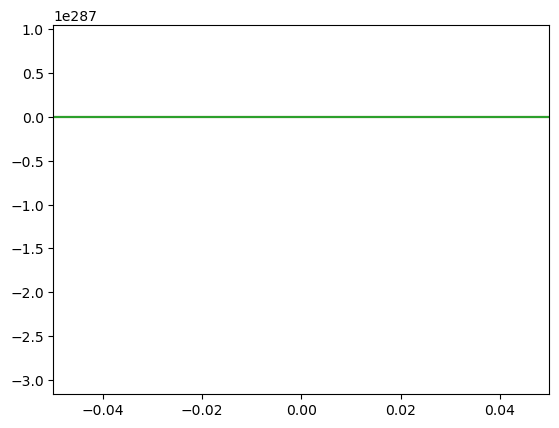

In [78]:
amp = (0.5*mmax)
fit.original_data['H1'] = qnm_filter.RealData(signal221, index=t_range)
analytical_waveform = amp*B*np.exp(-(t_range/(tau221*mass)))*np.cos((omega221/mass)*t_range+psi)
analytical_waveform[t_range>0] = 0

fit.filtered_data['H1'].plot()
fit.original_data['H1'].plot()
pl.plot(t_range, analytical_waveform)
# pl.axvline(0, c='r', ls='--')
pl.xlim(-0.05, 0.05)

In [ ]:
test = fit.filtered_data['H1'].values
test[fit.filtered_data['H1'].index<0] = 0
np.sum(test**2)

In [60]:
def SNRres_calc(omega, tau, phi, psi, B):
    temp0 = B**2*tau/(4+4*tau**2*omega**2)
    temp1 = 1+tau**2*omega**2+np.cos(2*(phi+psi))-tau*omega*np.sin(2*(phi+psi))
    return temp0/temp1

In [65]:
SNRres_calc(omega221, tau221, 0, psi, B)*(0.5*mmax)**2

6.601773985278516e-43

In [ ]:
def RF_calc(chi, phi=0):
    w220, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=chi)
    w221, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=chi)
    omega220 = np.real(w220)
    tau220 = 1/np.imag(w220)
    filt = (w221-w220)/(w221-np.conj(w220))*(w221+np.conj(w220))/(w221+w220)
    B = np.abs(filt)
    psi = np.arccos(np.real(filt))
    RF = B**2*(1+tau220**2*omega220**2+np.cos(2*(phi+psi))-omega220*tau220*np.sin(2*(phi+psi))/(1+tau220**2*omega220**2+np.cos(2*phi)-tau220*omega220*np.sin(2*phi)))
    return RF, B